In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from datetime import datetime as dt
import seaborn as sns
from matplotlib.collections import LineCollection
from pathlib import Path
from scipy import spatial
from scipy.stats import binned_statistic_2d
from tqdm import tqdm


from good_robot.location_history_parse import *
from good_robot.gram import layer_to_lines, lines_to_layer, Turtle
from good_robot import write
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
%%time
df = pd.read_parquet('/mnt/c/data/side/Location History/Location History.parquet')


CPU times: user 2.53 s, sys: 4.77 s, total: 7.3 s
Wall time: 3.61 s


In [ ]:
# just in the bay
big_bay_lims = get_big_bay_lims()
bb_ind = spatial_filter_df(df, big_bay_lims)
df = df[bb_ind]

In [ ]:
# just 2019
# df = df.loc['2019-01-01':'2019-12-31']

## simple binning

In [ ]:
def interleave_with_nans(a):
    # a should be 1D
    nans = a.copy()
    nans[:] = np.nan
    interleaved = np.empty((a.size + nans.size), dtype=a.dtype)
    interleaved[0::2] = a
    interleaved[1::2] = nans
    return interleaved

In [ ]:
def points_to_small_random_lines(a, mu=0, std=1):
    # a should be 1D
    nans = a.copy()
    nans[:] = np.nan
    
    noisy_a = a + np.random.randn(*a.shape) * std + mu
    
    interleaved = np.empty((a.size + a.size + nans.size), dtype=a.dtype)
    interleaved[0::3] = a
    interleaved[1::3] = noisy_a
    interleaved[2::3] = nans
    return interleaved

In [ ]:
def points_to_small_lines(a, summand=0):
    # a should be 1D
    nans = a.copy()
    nans[:] = np.nan
    
    a_sum = a + np.array(summand)
    
    interleaved = np.empty((a.size + a.size + nans.size), dtype=a.dtype)
    interleaved[0::3] = a
    interleaved[1::3] = a_sum
    interleaved[2::3] = nans
    return interleaved

In [ ]:
def lines_and_line_inds_to_tree(lines, line_inds, n_points):
    line_tree = []
    line_ind_tree = []
    for i in range(n_points):
        lines_starting_here_inds = np.where(line_inds[:,0] == i)[0]
        lines_starting_here = []
        line_inds_here = []
        for ind in lines_starting_here_inds:
            lines_starting_here.append(lines[ind])
            line_inds_here.append(line_inds[ind,:])

        line_tree.append(lines_starting_here)
        line_ind_tree.append(line_inds_here)
    return line_tree, line_ind_tree

In [ ]:
def flatten_short_tree(tree):
    flat_list= []
    for list_set in line_tree:
        for _list in list_set:
            flat_list.append(_list.copy())
    return flat_list

In [ ]:
H, xedges, yedges = np.histogram2d(x=df['lon'], y=df['lat'], bins=1000)

x_mesh, y_mesh = np.meshgrid(xedges[:-1], yedges[:-1], indexing='ij')

x_mesh = x_mesh.flatten()
y_mesh = y_mesh.flatten()
H = H.flatten()
nonzero = H>0
xs = x_mesh[nonzero]
ys = y_mesh[nonzero]

f, ax = plt.subplots(figsize=(10,10))
ax.plot(xs, ys,  '.', alpha=0.1)

In [ ]:
# nxs = points_to_small_random_lines(xs, std=0.001)
# nys = points_to_small_random_lines(ys, std=0.001)
# layer = np.stack([nxs, nys])

nxs = points_to_small_lines(xs, summand=0)
nys = points_to_small_lines(ys, summand=0.0005)
layer = np.stack([nxs, nys])

In [ ]:
savedir = Path('/mnt/c/code/side/good_robot/images')
filename = '0023_loc_hist_point_bins.svg'
save_filepath = savedir.joinpath(filename)
write.write_plot(plot=[layer], filename=save_filepath, margin=0.2)

In [ ]:
lines = layer_to_lines(layer)

(-122.62222279024166,
 -122.12851220492499,
 37.58025154211667,
 38.019788615550006)

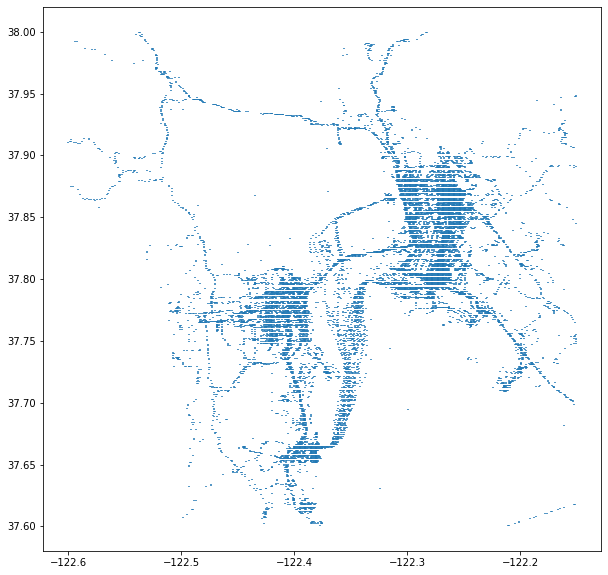

In [ ]:
f, ax = plt.subplots(figsize=(10,10))
ax.add_collection(LineCollection(lines))
ax.axis('tight')

# make a gram at each bin loc

In [ ]:
H, xedges, yedges = np.histogram2d(x=df['lon'], y=df['lat'], bins=500)

x_mesh, y_mesh = np.meshgrid(xedges[:-1], yedges[:-1], indexing='ij')

x_mesh = x_mesh.flatten()
y_mesh = y_mesh.flatten()
H = H.flatten()
nonzero = H>0
xs = x_mesh[nonzero]
ys = y_mesh[nonzero]


In [ ]:
turtles = []
for x,y in zip(xs, ys):
    tur = Turtle(x=x, y=y)
    tur.pen_down()
    tur.circle(radius=0.005, n_eval_points=20)
    turtles.append(tur)

(-122.62370157895653,
 -122.12668327524348,
 37.580125360752135,
 38.07714366446518)

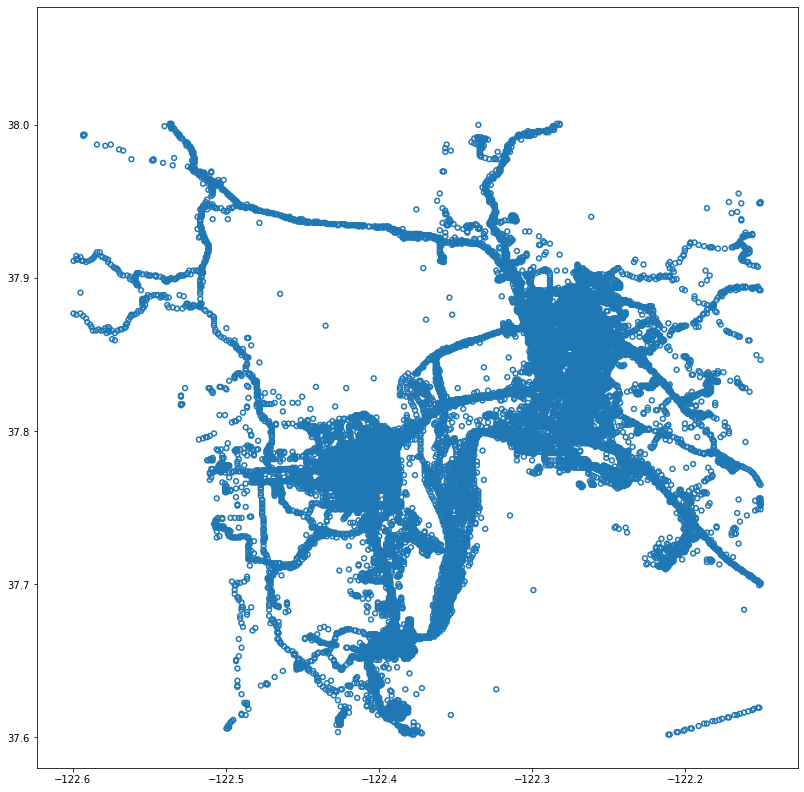

In [ ]:
all_lines = np.concatenate([tur.lines for tur in turtles], axis=1)
lc = LineCollection(layer_to_lines(all_lines))
f,ax = plt.subplots(figsize=(14,14))
ax.add_collection(lc)
ax.axis('tight')
ax.axis('square')

In [ ]:
savedir = Path('/mnt/c/code/side/good_robot/images')
filename = '0034_loc_hist_point_grams.svg'
save_filepath = savedir.joinpath(filename)
write.write_plot(plot=[all_lines], filename=save_filepath, margin=0.2)

# merging lines

In [ ]:
H, xedges, yedges = np.histogram2d(x=df['lon'], y=df['lat'], bins=300)

x_mesh, y_mesh = np.meshgrid(xedges[:-1], yedges[:-1], indexing='ij')

x_mesh = x_mesh.flatten()
y_mesh = y_mesh.flatten()
H = H.flatten()
nonzero = H>0
xs = x_mesh[nonzero]
ys = y_mesh[nonzero]
points = np.stack([xs, ys]).T

In [ ]:
(df['dpos'] / df['dposm']).mean()

1.0229981822803892e-05

.00001 = 1m

In [ ]:
radius = .005 #50m
kdtree = spatial.cKDTree(points)
neigh_list = []
# We cycle on every point and calculate its neighbours 
# with the function query_ball_point
for point in tqdm(points):
    neigh_list.append(kdtree.query_ball_point(point, r=radius))

100%|██████████| 33103/33103 [00:47<00:00, 702.06it/s]


In [ ]:
%%time
radius = .01 #  300m
kdtree = spatial.cKDTree(points)
ds, nns = kdtree.query(points, k=5, distance_upper_bound=radius)
conn_lines = []
conn_line_inds = []

for i, nn_inds in tqdm(enumerate(nns)):
    this_pt = points[i,:]
    _ds = ds[i,:]
    valid_d_ind = (0 < _ds) & (_ds < np.inf)
    valid_nn_inds = nn_inds[valid_d_ind]
    valid_ds = _ds[valid_d_ind]
    for nn_ind in valid_nn_inds:
        neighbor_pt = points[nn_ind,:].squeeze()
        conn_lines.append(np.stack([this_pt, neighbor_pt]))
        conn_line_inds.append([i, nn_ind])
        
conn_line_inds = np.stack(conn_line_inds)



10113it [00:00, 20539.80it/s]


CPU times: user 562 ms, sys: 31.2 ms, total: 594 ms
Wall time: 591 ms


In [ ]:
%%time
kdtree = spatial.cKDTree(points)
qbt = kdtree.query_ball_tree(kdtree, r=radius)

conn_lines = []
for i, neighbor_ind_set in tqdm(enumerate(nns)):
    neighbor_inds = [ind for ind in neighbor_ind_set if (not ind==i)]
    this_point = points[i,:]
    if len(neighbor_inds) > 0:
        neighbor_pts = points[neighbor_inds,:]
        for neighbor_pt in neighbor_pts:
            conn_lines.append(np.stack([this_point, neighbor_pt]))

2it [00:00,  8.59it/s]


(-122.622237776145, -122.12819750095498, 37.58026321727, 38.01954343733)

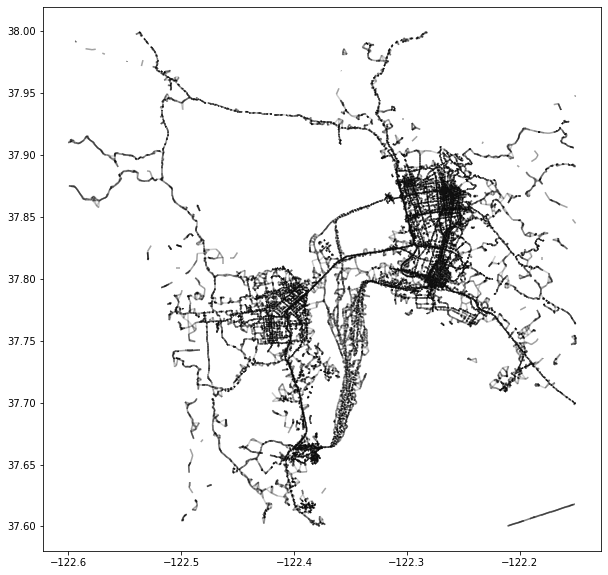

In [ ]:

f, ax = plt.subplots(figsize=(10,10))
ax.add_collection(LineCollection(conn_lines, color='k', alpha=0.2))
ax.axis('tight')

In [ ]:
lines = conn_lines.copy()
line_inds = conn_line_inds.copy()
line_tree, line_ind_tree = lines_and_line_inds_to_tree(lines, line_inds, n_points=len(points))
lt = line_tree.copy()
lit = line_ind_tree.copy()
n_originating_lines = np.array([len(ind_set) for ind_set in lit])
parent_points = np.where(n_originating_lines > 0)[0]

In [ ]:
def merge_nearby_lines(line_tree, line_ind_tree, n_iters, remove_reciprocals=False):
    lt = line_tree.copy()
    lit = line_ind_tree.copy()
    n_originating_lines = np.array([len(ind_set) for ind_set in lit])
    parent_points = np.where(n_originating_lines > 0)[0]
    num_parent_points = np.zeros(n_iters)
    for i in tqdm(range(n_iters)):
        start_pt_ind = np.random.choice(parent_points)
        n_lines_originating_here = n_originating_lines[start_pt_ind]
        if n_lines_originating_here > 0:
            sub_line_pick = np.random.choice(n_lines_originating_here)
    #         sub_line_pick = 0
            curr_line = lt[start_pt_ind].pop(sub_line_pick)
            curr_line_ind = lit[start_pt_ind].pop(sub_line_pick)

            end_pt_ind = curr_line_ind[-1]

            
            if remove_reciprocals:
                # remove line doubling back
                for i, end_pt_line_ind in enumerate(lit[end_pt_ind]):
                    if end_pt_line_ind[-1] == start_pt_ind:
                        lit[end_pt_ind].pop(i)
                        lt[end_pt_ind].pop(i)

            if len(lt[end_pt_ind]) > 0:
                next_line_pick = np.random.choice(len(lt[end_pt_ind]))
    #             next_line_pick = 0
                # merge lines
                next_line = lt[end_pt_ind].pop(next_line_pick)
                next_line_ind = lit[end_pt_ind].pop(next_line_pick)
                curr_line = np.concatenate([curr_line, next_line[1:,:]])
                curr_line_ind = np.concatenate([curr_line_ind, next_line_ind[1:]])

            n_originating_lines[end_pt_ind] = len(lt[end_pt_ind])
            n_originating_lines[start_pt_ind] = len(lt[start_pt_ind])





            # add line to tree
            lt[start_pt_ind].append(curr_line)
            lit[start_pt_ind].append(curr_line_ind)

            parent_points = np.where(n_originating_lines > 0)[0]

        num_parent_points[i] = len(parent_points)
        
    return lt, lit, num_parent_points

In [ ]:
n_iters = 300000
num_parent_points = np.zeros(n_iters)
for i in tqdm(range(n_iters)):
    start_pt_ind = np.random.choice(parent_points)
    n_lines_originating_here = n_originating_lines[start_pt_ind]
    if n_lines_originating_here > 0:
        sub_line_pick = np.random.choice(n_lines_originating_here)
#         sub_line_pick = 0
        curr_line = lt[start_pt_ind].pop(sub_line_pick)
        curr_line_ind = lit[start_pt_ind].pop(sub_line_pick)

        end_pt_ind = curr_line_ind[-1]
        
            
        # remove line doubling back
        for i, end_pt_line_ind in enumerate(lit[end_pt_ind]):
            if end_pt_line_ind[-1] == start_pt_ind:
                lit[end_pt_ind].pop(i)
                lt[end_pt_ind].pop(i)
                

        
        if len(lt[end_pt_ind]) > 0:
            next_line_pick = np.random.choice(len(lt[end_pt_ind]))
#             next_line_pick = 0
            # merge lines
            next_line = lt[end_pt_ind].pop(next_line_pick)
            next_line_ind = lit[end_pt_ind].pop(next_line_pick)
            curr_line = np.concatenate([curr_line, next_line[1:,:]])
            curr_line_ind = np.concatenate([curr_line_ind, next_line_ind[1:]])
            
            
        n_originating_lines[end_pt_ind] = len(lt[end_pt_ind])
        n_originating_lines[start_pt_ind] = len(lt[start_pt_ind])
        
        
        
            

        # add line to tree
        lt[start_pt_ind].append(curr_line)
        lit[start_pt_ind].append(curr_line_ind)
        
        parent_points = np.where(n_originating_lines > 0)[0]
        
    num_parent_points[i] = len(parent_points)

100%|██████████| 300000/300000 [00:16<00:00, 18541.13it/s]


In [ ]:
n_iters = 1000000
num_parent_points = np.zeros(n_iters)
for i in tqdm(range(n_iters)):
    start_pt_ind = np.random.choice(parent_points)
    n_lines_originating_here = n_originating_lines[start_pt_ind]
    places_to_go = 
    if n_lines_originating_here > 0:
        sub_line_pick = np.random.choice(n_lines_originating_here)
        curr_line = lt[start_pt_ind].pop(sub_line_pick)
        curr_line_ind = lit[start_pt_ind].pop(sub_line_pick)

        end_pt_ind = curr_line_ind[-1]
        
            
        # remove line doubling back
        for i, end_pt_line_ind in enumerate(lit[end_pt_ind]):
            if end_pt_line_ind[-1] == start_pt_ind:
                lit[end_pt_ind].pop(i)
                lt[end_pt_ind].pop(i)
                

        
        if len(lt[end_pt_ind]) > 0:
            next_line_pick = np.random.choice(len(lt[end_pt_ind]))

            # merge lines
            next_line = lt[end_pt_ind].pop(next_line_pick)
            next_line_ind = lit[end_pt_ind].pop(next_line_pick)
            curr_line = np.concatenate([curr_line, next_line[1:,:]])
            curr_line_ind = np.concatenate([curr_line_ind, next_line_ind[1:]])
            
            
        n_originating_lines[end_pt_ind] = len(lt[end_pt_ind])
        n_originating_lines[start_pt_ind] = len(lt[start_pt_ind])
        
        if n_originating_lines[end_pt_ind] < 1:
            parent_points = parent_points[~(parent_points==end_pt_ind)]
            

        # add line to tree
        lt[start_pt_ind].append(curr_line)
        lit[start_pt_ind].append(curr_line_ind)
        
        num_parent_points[i] = len(parent_points)

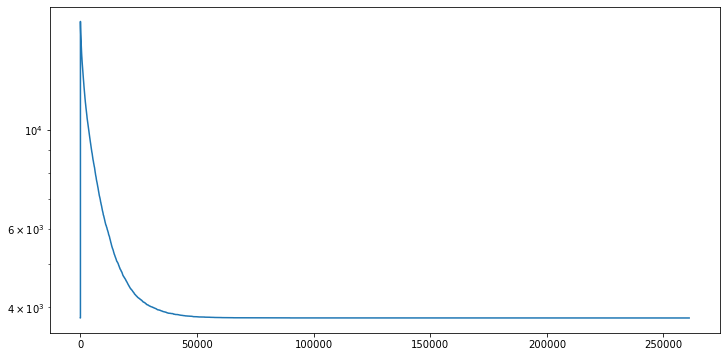

In [ ]:
f,ax = plt.subplots(figsize=(12,6))
ax.plot(num_parent_points[num_parent_points>0])
ax.set_yscale('log')

In [ ]:
all_lens = []
for line_ind_set in lit:
    for line_ind in line_ind_set:
        all_lens.append(len(line_ind))
all_lens = np.array(all_lens)

4.740810769928906


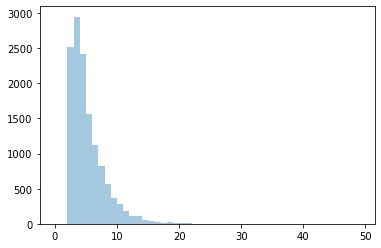

In [ ]:
sns.distplot(all_lens, kde=False, bins = np.arange(50))
print(all_lens.mean())

(-122.62221529729, -122.12866955690998, 37.58028320454, 38.019123704660004)

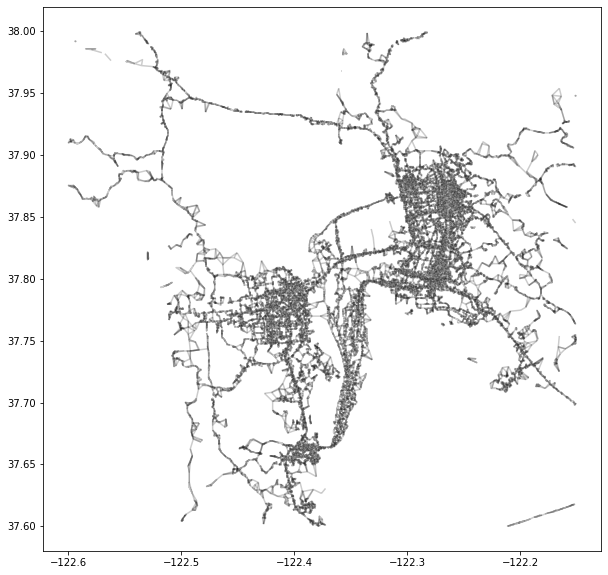

In [ ]:
merged_lines = flatten_short_tree(lt)
merged_line_inds = flatten_short_tree(lit)
f, ax = plt.subplots(figsize=(10,10))
ax.add_collection(LineCollection(merged_lines, color='k', alpha=0.2))
ax.axis('tight')

In [ ]:
savedir = Path('/mnt/c/code/side/good_robot/images')
filename = '0025_loc_hist_point_bins_nn_linked.svg'
save_filepath = savedir.joinpath(filename)
write.write_plot(plot=[lines_to_layer(merged_lines)], filename=save_filepath, margin=0.2)

In [ ]:
def d_to_p(ds):
    p = 1 / (ds ** 2)
    p = p / p.sum()
    return p

In [ ]:
n_visits_allowed = 8
n_visits = np.ones(len(points)) * n_visits_allowed

radius = 1 #  400m
kdtree = spatial.cKDTree(points)

visits_remaining = np.where(n_visits>0)[0]

lines = []
line_inds = []
n_visits_sum = n_visits.sum()
n_visits_sums = []

count = 0
while n_visits_sum > 0:
    orig_pt_ind = np.random.choice(visits_remaining)
    orig_pt = points[[orig_pt_ind]]
    start_pt = orig_pt.copy()
    current_line = start_pt.copy()
    current_line_ind = [orig_pt_ind]
    dead_end = False
    n_visits[orig_pt_ind] -= 1
    count += 1
    if count % 100 == 0:
        print(f'iter {count} : n_visits left = {n_visits_sum}')
    
    while not dead_end:
        ds, nn_inds = kdtree.query(start_pt, k=10, distance_upper_bound=radius)
        valid_d_ind = (0 < ds) & (ds < np.inf)
        ds = ds[valid_d_ind]
        nn_inds = nn_inds[valid_d_ind]
        visits_left = (n_visits[nn_inds] > 0)
        nn_inds = nn_inds[visits_left]
        ds = ds[visits_left]
        not_already_touched = ~np.in1d(nn_inds, current_line_ind)
        valid_nn_inds = nn_inds[not_already_touched]
        valid_ds = ds[not_already_touched]
        if len(valid_nn_inds) > 0:
#             sub_ind = np.random.choice(len(valid_nn_inds), p=d_to_p(valid_ds))
            sub_ind = np.random.choice(len(valid_nn_inds))
            next_pt_ind = valid_nn_inds[sub_ind]
            d_to_next_pt = valid_ds[sub_ind]
            next_pt = points[[next_pt_ind]]
            current_line = np.concatenate([current_line, next_pt], axis=0)
            current_line_ind.append(next_pt_ind)
            n_visits[next_pt_ind] -= 1

            # search with momentum
            vec = next_pt - start_pt
            angle = np.arctan2(vec[0,1], vec[0,0])
            dx = np.cos(angle) * d_to_next_pt * 2
            dy = np.sin(angle) * d_to_next_pt * 2
            start_pt = start_pt + np.array([dx, dy])

        elif len(valid_nn_inds) == 0:
            if current_line.shape[0] > 1:
                lines.append(current_line.copy())
                line_inds.append(current_line_ind.copy())
#             elif current_line.shape[0] == 1:
#                 n_visits[orig_pt_ind] += 1
            dead_end = True
    n_visits_sum = n_visits.sum()
    n_visits_sums.append(n_visits_sum)

iter 100 : n_visits left = 58467.0
iter 200 : n_visits left = 40429.0
iter 300 : n_visits left = 32210.0
iter 400 : n_visits left = 26106.0
iter 500 : n_visits left = 21259.0
iter 600 : n_visits left = 18074.0
iter 700 : n_visits left = 15409.0
iter 800 : n_visits left = 13305.0
iter 900 : n_visits left = 11911.0
iter 1000 : n_visits left = 10851.0
iter 1100 : n_visits left = 9964.0
iter 1200 : n_visits left = 9057.0
iter 1300 : n_visits left = 8230.0
iter 1400 : n_visits left = 7535.0
iter 1500 : n_visits left = 6848.0
iter 1600 : n_visits left = 6300.0
iter 1700 : n_visits left = 5692.0
iter 1800 : n_visits left = 5181.0
iter 1900 : n_visits left = 4732.0
iter 2000 : n_visits left = 4290.0
iter 2100 : n_visits left = 3841.0
iter 2200 : n_visits left = 3459.0
iter 2300 : n_visits left = 3179.0
iter 2400 : n_visits left = 2944.0
iter 2500 : n_visits left = 2665.0
iter 2600 : n_visits left = 2418.0
iter 2700 : n_visits left = 2142.0
iter 2800 : n_visits left = 1922.0
iter 2900 : n_visit

In [ ]:
n_points = len(points)
line_tree = [[] for i in range(n_points)]
line_ind_tree = [[] for i in range(n_points)]
for line, line_ind in zip(lines,line_inds):
    start_pt_ind = line_ind[0]
    line_tree[start_pt_ind].append(line.copy())
    line_ind_tree[start_pt_ind].append(line_ind.copy())

In [ ]:
lt, lit, nparents = merge_nearby_lines(line_tree, line_ind_tree, n_iters=10000, remove_reciprocals=False)

100%|██████████| 10000/10000 [00:00<00:00, 28787.52it/s]


In [ ]:
lines = flatten_short_tree(lt)
line_inds = flatten_short_tree(lit)


In [ ]:
lines = [line for line in lines if (len(line) > 8)]

73.02707930367505


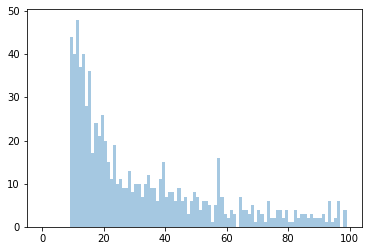

In [ ]:
all_lens = np.array([len(line) for line in lines])

sns.distplot(all_lens, kde=False, bins = np.arange(100))
print(all_lens.mean())

(-122.62218532548333, -122.12929896485, 37.580309854233334, 38.0185640611)

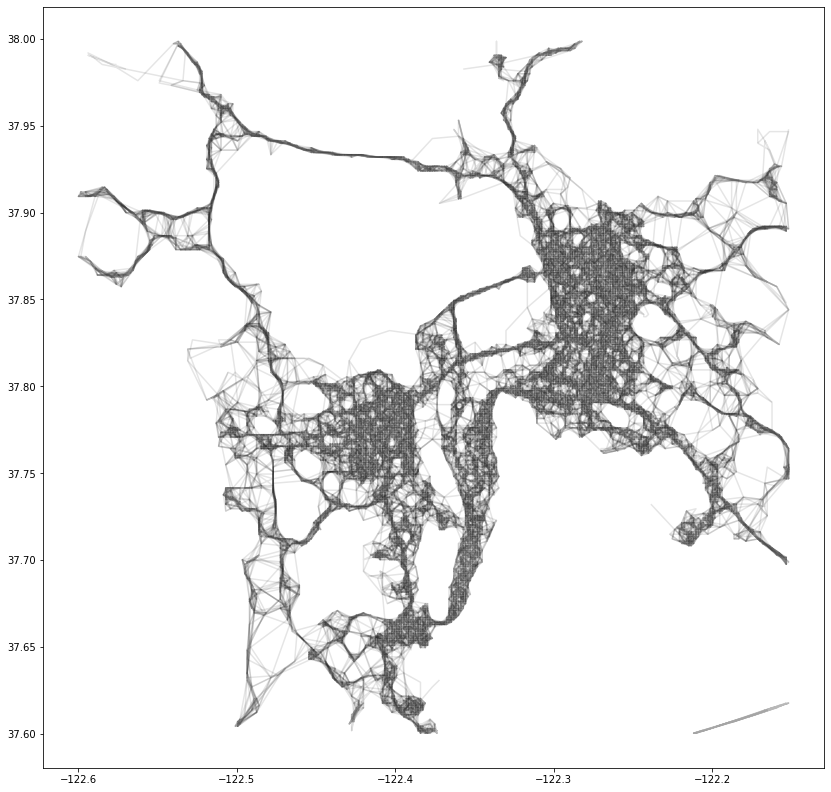

In [ ]:
f, ax = plt.subplots(figsize=(14,14))
ax.add_collection(LineCollection(lines, color='k', alpha=0.1))
ax.axis('tight')

In [ ]:
savedir = Path('/mnt/c/code/side/good_robot/images')
filename = '0042_loc_hist_point_bins_nn_super_linked_big_no_repeat.svg'
save_filepath = savedir.joinpath(filename)
write.write_plot(plot=[lines_to_layer(lines)], filename=save_filepath, margin=0.2)

# find flows

In [ ]:
df['angle'] = np.arctan2(df['dlat'], df['dlon'].values).fillna(0)

In [ ]:
df['orientation'] = df['angle'] % (np.pi)

In [ ]:
locs = df.loc[:, ['lon','lat']].values

In [ ]:
H, xedges, yedges = np.histogram2d(x=df['lon'], y=df['lat'], bins=500)
x_mesh, y_mesh = np.meshgrid(xedges[:-1], yedges[:-1], indexing='ij')
x_mesh = x_mesh.flatten()
y_mesh = y_mesh.flatten()
H = H.flatten()
nonzero = H>0
xs = x_mesh[nonzero]
ys = y_mesh[nonzero]

In [ ]:
stats, xedges, yedges, binnum = binned_statistic_2d(
    x=df['lon'].values,
    y=df['lat'].values,
    values=df['orientation'].fillna(0).values,
    statistic='mean',
    bins=(xedges,yedges))
_stats = stats.ravel()
orientations = _stats[~np.isnan(_stats)]

In [ ]:
clipped_mpers = df['mpers'].fillna(0).values
clipped_mpers[clipped_mpers > 45] = 45

mpers, xedges, yedges, binnum = binned_statistic_2d(
    x=df['lon'].values,
    y=df['lat'].values,
    values=clipped_mpers ,
    statistic='mean',
    bins=(xedges,yedges))
_mpers = mpers.ravel()
mpers = _mpers[~np.isnan(_mpers)]

100%|██████████| 17516/17516 [00:00<00:00, 106234.20it/s]


(-122.62708958122917,
 -122.12191512676563,
 37.58000958642036,
 38.024869685172455)

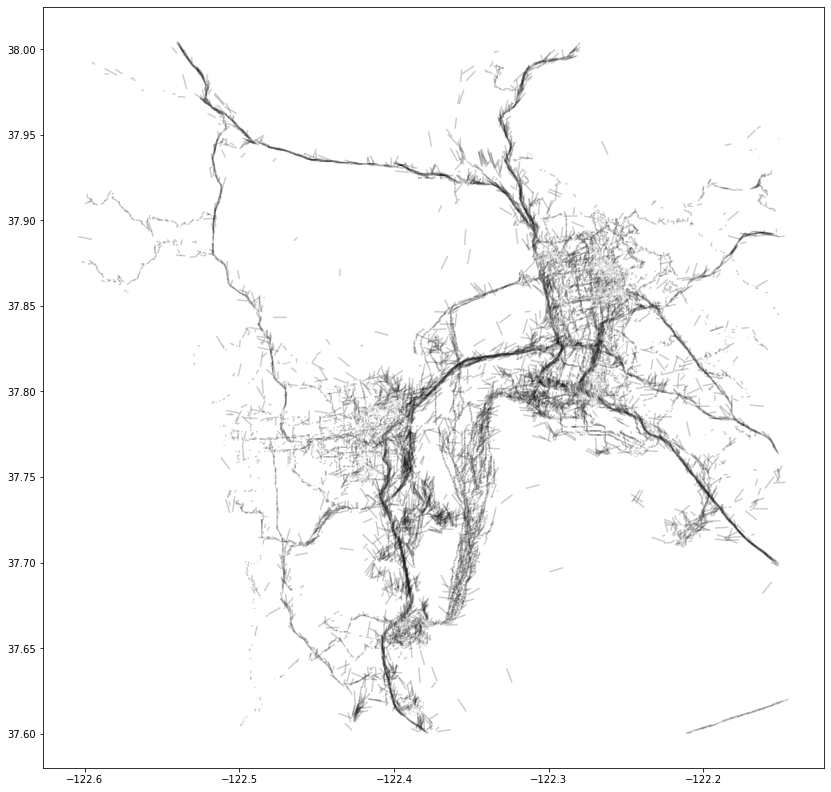

In [ ]:
dxs = np.cos(orientations)
dys = np.sin(orientations)

dscale = 0.0002

points = np.stack([xs,ys]).T
dpoints = (np.stack([dxs,dys]) * mpers).T * dscale

lines = []
for i in tqdm(range(len(points))):
    pt = points[[i]]
    dpt = dpoints[[i]]
    
    lines.append(np.concatenate([pt, pt + dpt], axis=0))

f, ax = plt.subplots(figsize=(14,14))
ax.add_collection(LineCollection(lines, color='k', alpha=0.2))
ax.axis('tight')

100%|██████████| 17516/17516 [00:00<00:00, 113332.11it/s]


(-122.62709115016716,
 -122.12188217906781,
 37.580007670811256,
 38.024909912963736)

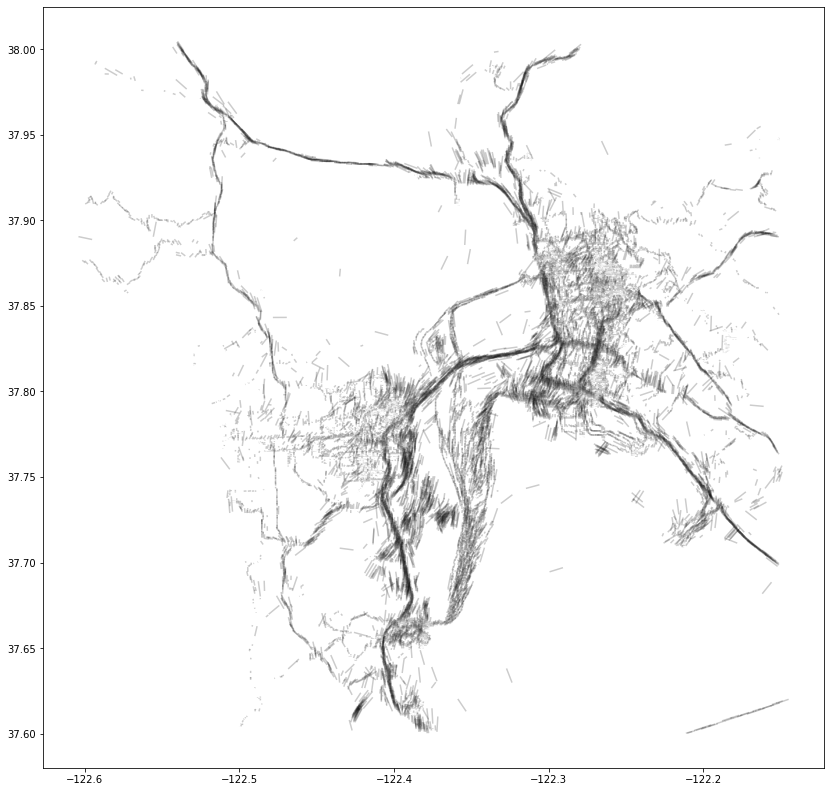

In [ ]:
smoothing_rad = 0.005

kdtree = spatial.cKDTree(points)
nn_inds = kdtree.query_ball_point(points, r=smoothing_rad)

smoothed_orientations = np.ones(orientations.shape) * np.nan

for i in tqdm(range(len(nn_inds))):
    nn_ind = nn_inds[i]
    smoothed_orientations[i] = np.median(orientations[nn_ind]) 
dxs = np.cos(smoothed_orientations)
dys = np.sin(smoothed_orientations)

dscale = 0.0002

points = np.stack([xs,ys]).T
# dpoints = np.stack([dxs,dys]).T * dscale
dpoints = (np.stack([dxs,dys]) * mpers).T * dscale

lines = []
for i in tqdm(range(len(points))):
    pt = points[[i]]
    dpt = dpoints[[i]]
    
    lines.append(np.concatenate([pt, pt + dpt], axis=0))

f, ax = plt.subplots(figsize=(14,14))
ax.add_collection(LineCollection(lines, color='k', alpha=0.2))
ax.axis('tight')

In [ ]:
savedir = Path('/mnt/c/code/side/good_robot/images')
filename = '0039_loc_hist_flow_bins_weighted_by_vel.svg'
save_filepath = savedir.joinpath(filename)
write.write_plot(plot=[lines_to_layer(lines)], filename=save_filepath, margin=0.2)

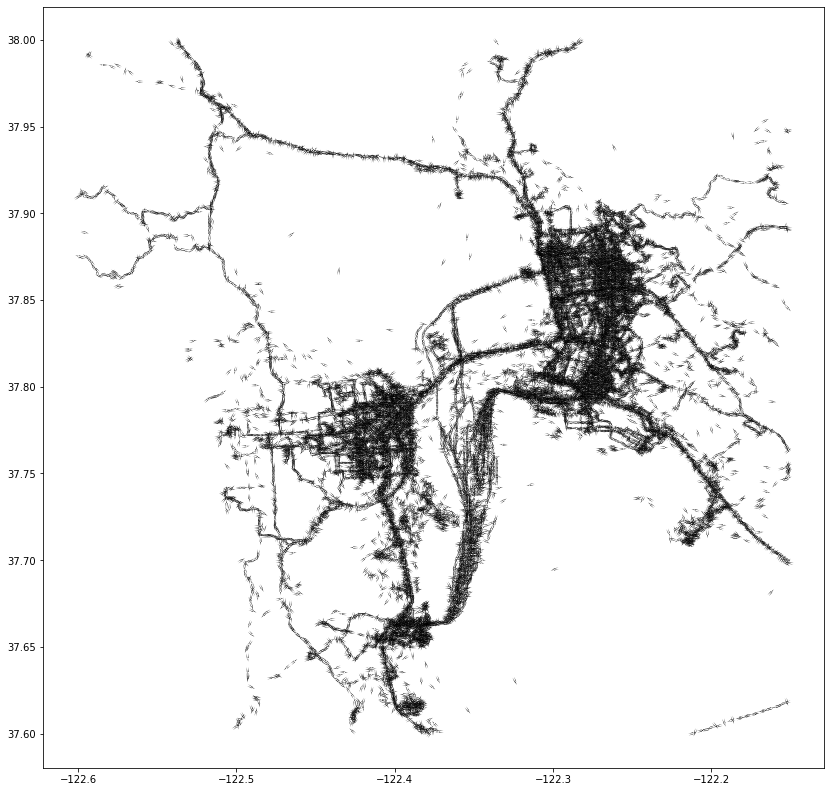

In [ ]:
f,ax = plt.subplots(figsize = (14,14))
ax.quiver(xs, ys, dxs*10, dys*10, headwidth=0, headlength=0)

# sampling trips

In [ ]:
H, xedges, yedges = np.histogram2d(x=df['lon'], y=df['lat'], bins=600)

x_mesh, y_mesh = np.meshgrid(xedges[:-1], yedges[:-1], indexing='ij')

x_mesh = x_mesh.flatten()
y_mesh = y_mesh.flatten()
H = H.flatten()
nonzero = H>0
xs = x_mesh[nonzero]
ys = y_mesh[nonzero]
points = np.stack([xs, ys]).T

In [ ]:
df['is_trip'] = get_is_trip_bool(
        df, 
        min_vel=0.1, 
        max_vel=35,
        max_dt=120,
        max_dposm=300,
    )

In [ ]:
stats, xedges, yedges, binnum = binned_statistic_2d(
    x=df['lon'].values,
    y=df['lat'].values,
    values=df['is_trip'].fillna(0).values,
    statistic='mean',
    bins=(xedges,yedges))
_stats = stats.ravel()
tripness = _stats[~np.isnan(_stats)]

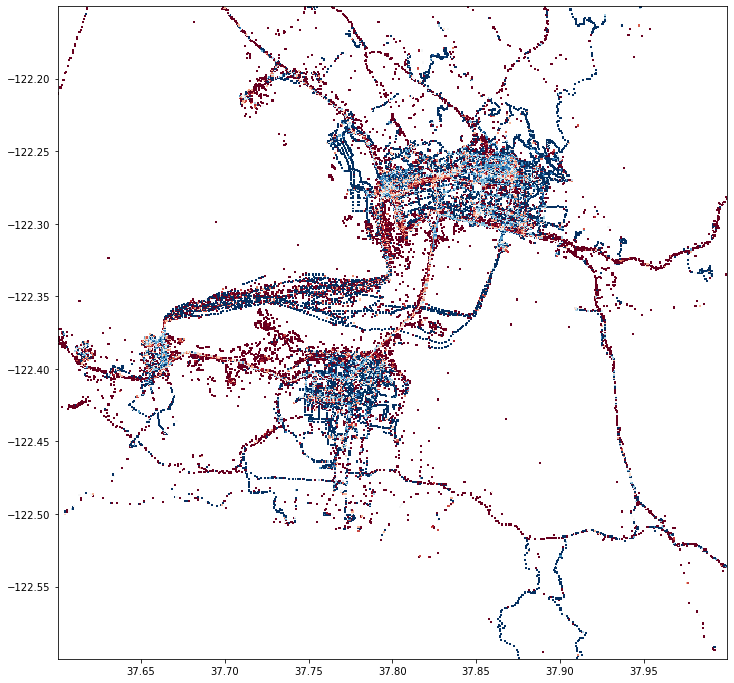

In [ ]:
f,ax = plt.subplots(figsize=(12,12))
c = ax.pcolormesh(xedges, yedges, stats, cmap='RdBu')